# Customization

In this tutorial, we want to give you an idea of the type of customizations you can make, while still using the convenience function `calculate_spectrum` for your calculations.

Let us again start by importing the necessary modules.

In [1]:
# NMR
from hqs_nmr.calculate import calculate_spectrum
from hqs_nmr.datatypes import NMRCalculationParameters, NMRSolverSettings, Isotope
from hqs_nmr import conversion

from hqs_nmr_parameters.examples import molecules

# external modules
import matplotlib.pyplot as plt
import numpy as np

# only to plot molecular structures (optional)
from rdkit.Chem import Draw, MolFromMolBlock

# Can be installed via HQStage and gives the plots a nice layout. This is an optional dependency.
import HQStyle
HQStyle.import_all()

# License check turned off.
/home/jkleinebuening/micromamba/envs/hqs-nmr/lib/python3.13/site-packages/hqs_nmr/solver/implementations/complete_solver.py:15: PerformanceWarning: Computation uses more threads than physical cores. Consider setting the OMP_NUM_THREADS environment variable to the number of physical cores: `export OMP_NUM_THREADS=12`.
  from hqs_quantum_solver.spins import (


In this example we want to choose a more complicated molecule. For this we will choose molecules from the `examples` module of the `hqs_nmr_parameters` package.

In [2]:
for key in molecules.keys:
    print(key)

camphor_DFT
CH3Cl_13C
C10H7Br
C2H5OH
cis-3-chloroacrylic_acid_exp
C2H3NC
CH3Cl
1,2-di-tert-butyl-diphosphane
exo-dicyclopentadiene_DFT
CHCl3_13C
Artemisinin_exp
C10H8
CHCl3
Anethole
H2CCF2
cyclopentadiene_DFT
endo-dicyclopentadiene_DFT
Artemisinin
limonene_DFT
Triphenylphosphine_oxide
C3H8
1,2,4-trichlorobenzene
C6H5NO2
Cinnamaldehyde
camphor_exp
C6H6
C2H3CN
C2H5Cl
C2H6
Androstenedione


Let's choose [camphor](https://en.wikipedia.org/wiki/Camphor). It has 16 spins and is therefore already quite complex.

In [3]:
molecule = molecules["camphor_DFT"]
molecule_parameters = molecule.spin_system()
print("Type of molecule:", type(molecule))
print("Type of molecule_parameters:", type(molecule_parameters))

Type of molecule: <class 'hqs_nmr_parameters.code.data_classes.MolecularData'>
Type of molecule_parameters: <class 'hqs_nmr_parameters.code.data_classes.NMRParameters'>


As you can see, we obtain an object of type `MolecularData` if we directly select a specific example molecule from the `molecules` dataset. It contains various molecular information including the NMR parameters that are needed for the spectrum simulation. By calling the `spin_system` method, we obtain an object of type `NMRParameters` that *only* contains the essential information to perform the spectrum simulation, i.e., the isotopes, chemical shifts, and *J*-coupling constants. Both objects can be used as input in the spectrum calculation functions, which are shown below. For a detailed introduction to this data structure, please have a look at [tutorial four](4_hqs_nmr_parameters_in_detail.ipynb).

If we want to check out the structure of our example molecule, we can again use [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html), note though, that for camphor the structure is only available in **Molfile** format, not as a SMILES string.

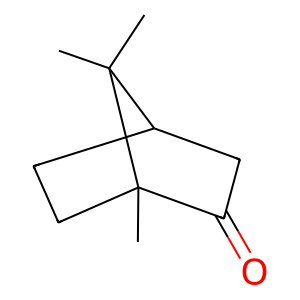

In [4]:
mol_string = molecule.structures["Molfile"].content
molecule_image_info = MolFromMolBlock(mol_string)
Draw.MolToImage(molecule_image_info)

We can again calculate the spectrum as in the first example assuming a magnetic field of 11.4733 T, corresponding to a 500 MHz spectrometer. Note that the `calculate_spectrum` function can take `MolecularData` or `NMRParameters` objects, so we can call it using `molecule` or `molecule_parameters`. We choose the latter option.

In [5]:
calculation_parameters = NMRCalculationParameters(field_T=11.7433)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

By default, if the molecule is too large to be solved directly, a spin dependent clustering approach is used to evaluate the spectrum. This solver strategy identifies for each spin an effective cluster with the most strongly coupled spins and solves it independently from the rest of the molecule. While this is an approximation it is typically extremely accurate, especially for high field NMR.


You can convince yourself of this for the example for camphor, by comparing to experimental results to [experimental results](https://bmrb.io/metabolomics/mol_summary/show_data.php?id=bmse001230), as we will do in the [fifth tutorial](./5_plot_spectra_hqsnmr_exp.ipynb). However, let's first analyze the results and learn more about the solver.

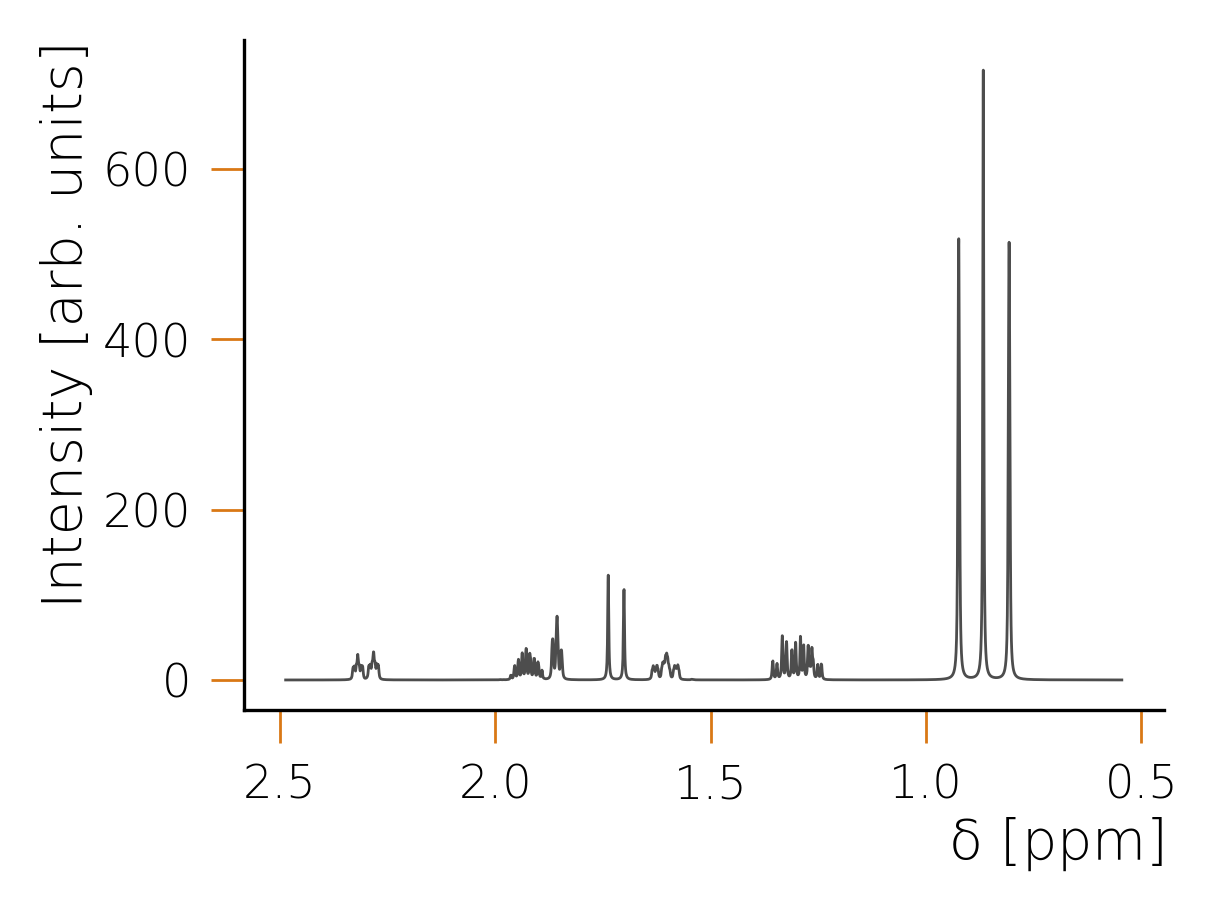

In [6]:
plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

If you compare the spectra carefully, you will see that the multiplet at 2.1 ppm in the experimental spectrum is shifted with respect to our results. The reason is not that the solver is wrong, but that the shifts in the input we are using for the calculations are based on DFT calculations and errors up to 0.3 ppm are normal. See for example [here](https://www.mdpi.com/1420-3049/28/6/2449).

## Adjusting solver settings

If you have specific requirements, you can also customize the solver backend to your needs. For this, you can use an object of the datatype `NMRSolverSettings`. In a first step we might want to improve runtime of the calculation. The easiest way to do this is, to reduce the maximum size of the clusters. We can also set a `verbose` attribute, to get some additional information on the calculation:

In [7]:
solver_settings = NMRSolverSettings(max_cluster_size=8, verbose=1)
calculation_parameters = NMRCalculationParameters(field_T=11.7433, solver_settings=solver_settings)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

cluster for spin(s) [0] :  [0, 1, 2, 3, 6, 13, 14, 15]
cluster for spin(s) [1, 2] :  [0, 1, 2, 3, 4, 5, 6, 15]
cluster for spin(s) [3] :  [0, 1, 2, 3, 4, 5, 6, 12]
cluster for spin(s) [4] :  [1, 2, 3, 4, 5, 6, 7, 9]
cluster for spin(s) [5] :  [0, 1, 2, 3, 4, 5, 10, 12]
cluster for spin(s) [6] :  [0, 1, 3, 4, 6, 10, 11, 12]
cluster for spin(s) [7, 8, 9] :  [4, 6, 7, 8, 9, 10, 11, 12]
cluster for spin(s) [10, 11, 12] :  [0, 6, 7, 8, 9, 10, 11, 12]
cluster for spin(s) [13, 14, 15] :  [0, 1, 2, 5, 12, 13, 14, 15]


In the output you can now see the indices of the clusters specified for each spin. Note that some of the spins have the same cluster. In this case the corresponding Hamiltonian is only diagonalized once for all contributions, reducing the runtime.

Let's now look at the calculated spectrum:

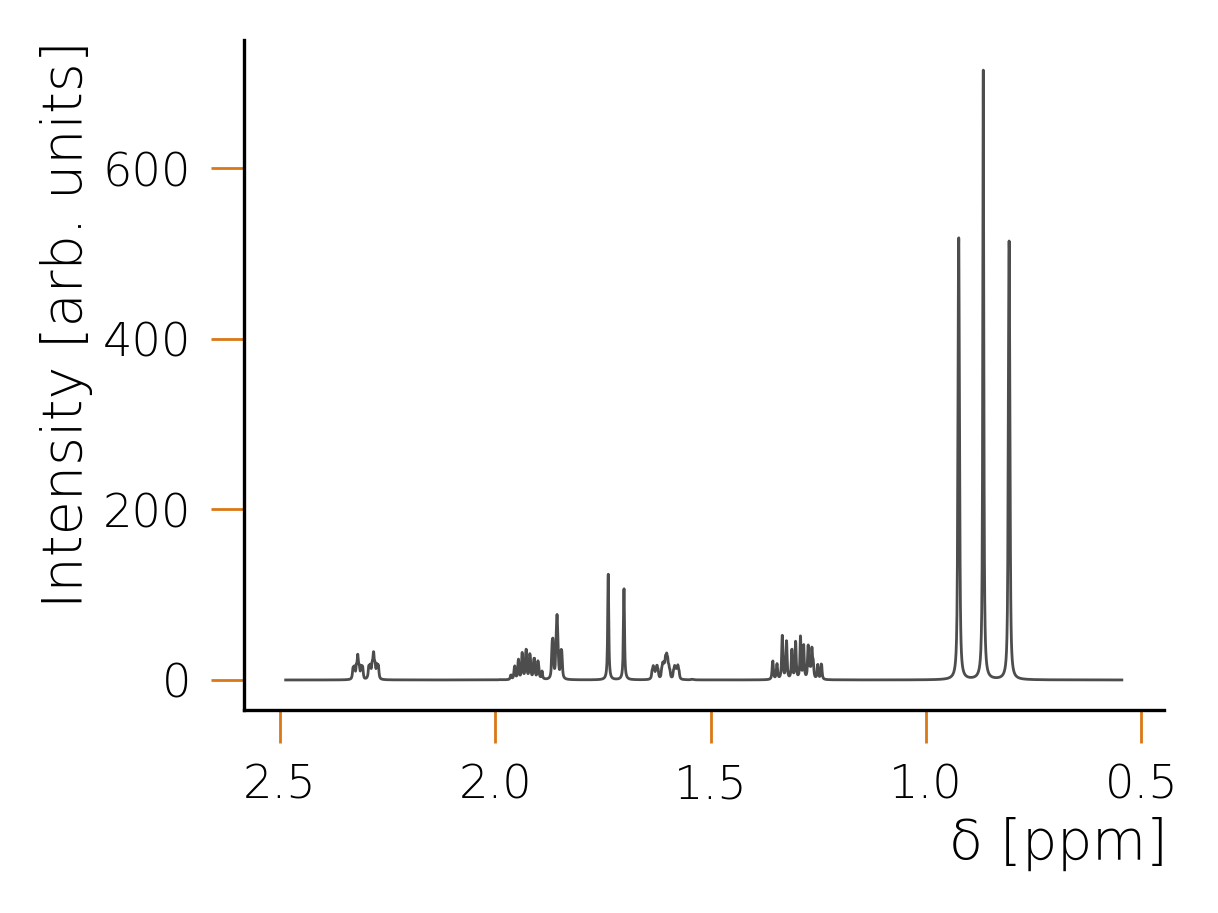

In [8]:
plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

As we can see, the result is basically still the same, while the runtime improved quite significantly. However, in case you are worried that this approximation is too crude for your molecule, you can also increase the maximum cluster size or even specify the attribute `perform_clustering=False` to avoid the clustering method completely. Feel free to uncomment the corresponding code block below. It should take around 5 minutes, however the result will basically look identical.

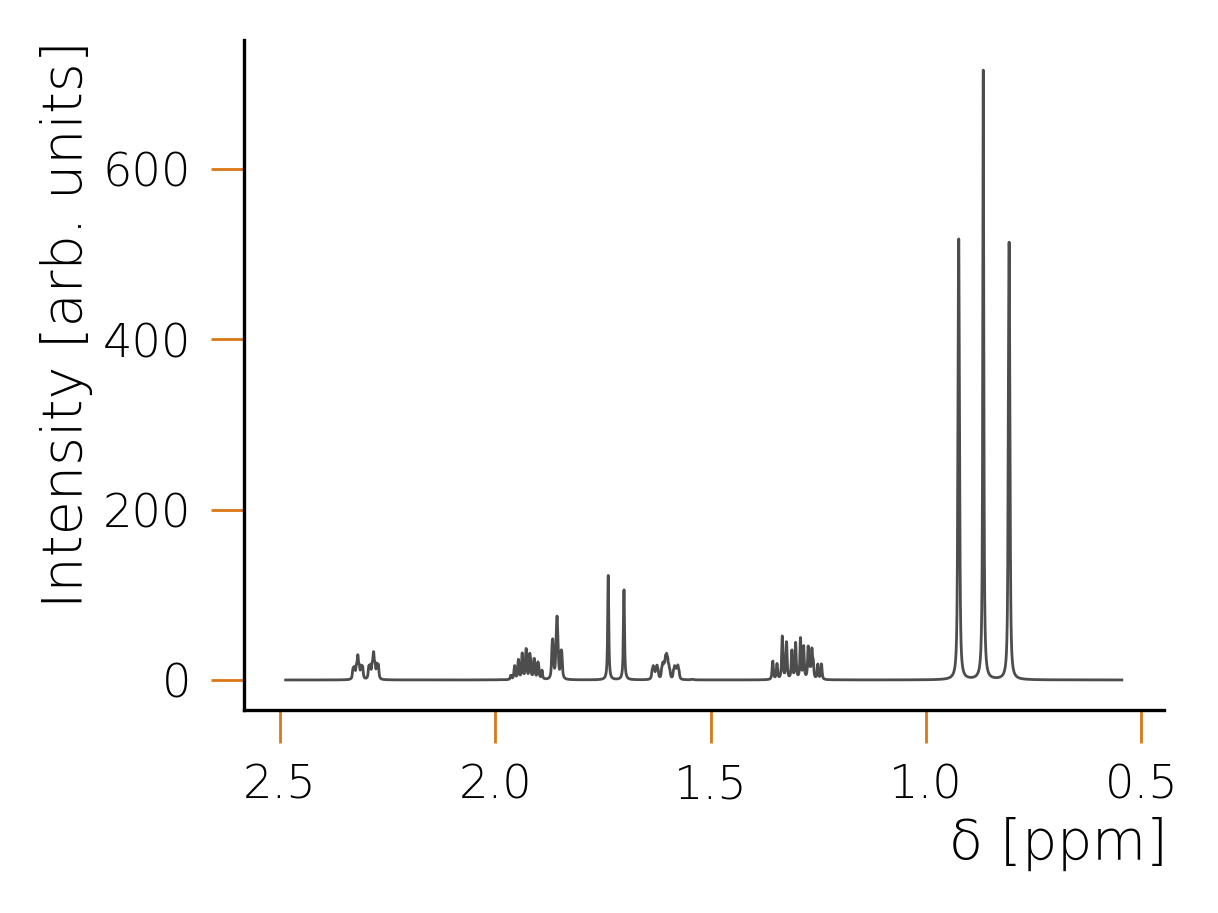

In [9]:
solver_settings = NMRSolverSettings(perform_clustering=False)
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433,
    solver_settings=solver_settings
)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

There are many more options to customize in the `NMRSolverSettings` object and we will come back to some of them in other tutorials. For now, though, we will focus on the other parameters in `NMRCalculationParameters` you can use to customize the spectrum calculations to your needs. To keep the runtime low, we will fix the maximum cluster size for all following calculations to eight spins:

In [10]:
solver_settings = NMRSolverSettings(max_cluster_size=8)

# Adapting the resolution

Most of the other attributes you can specify in `NMRCalculationParameters` determine the resolution of the final result. For example, you can adapt the width of the peaks in your spectrum. This broadening, if not set explicitly, is automatically introduced internally and is estimated from the spectrometer frequency. It is used to mimic the effects of noise. If you want to set it manually, you may do so via the argument `fwhm_Hz`. This will lead the peaks to have a full width at half maximum (FWHM) of the specified size.

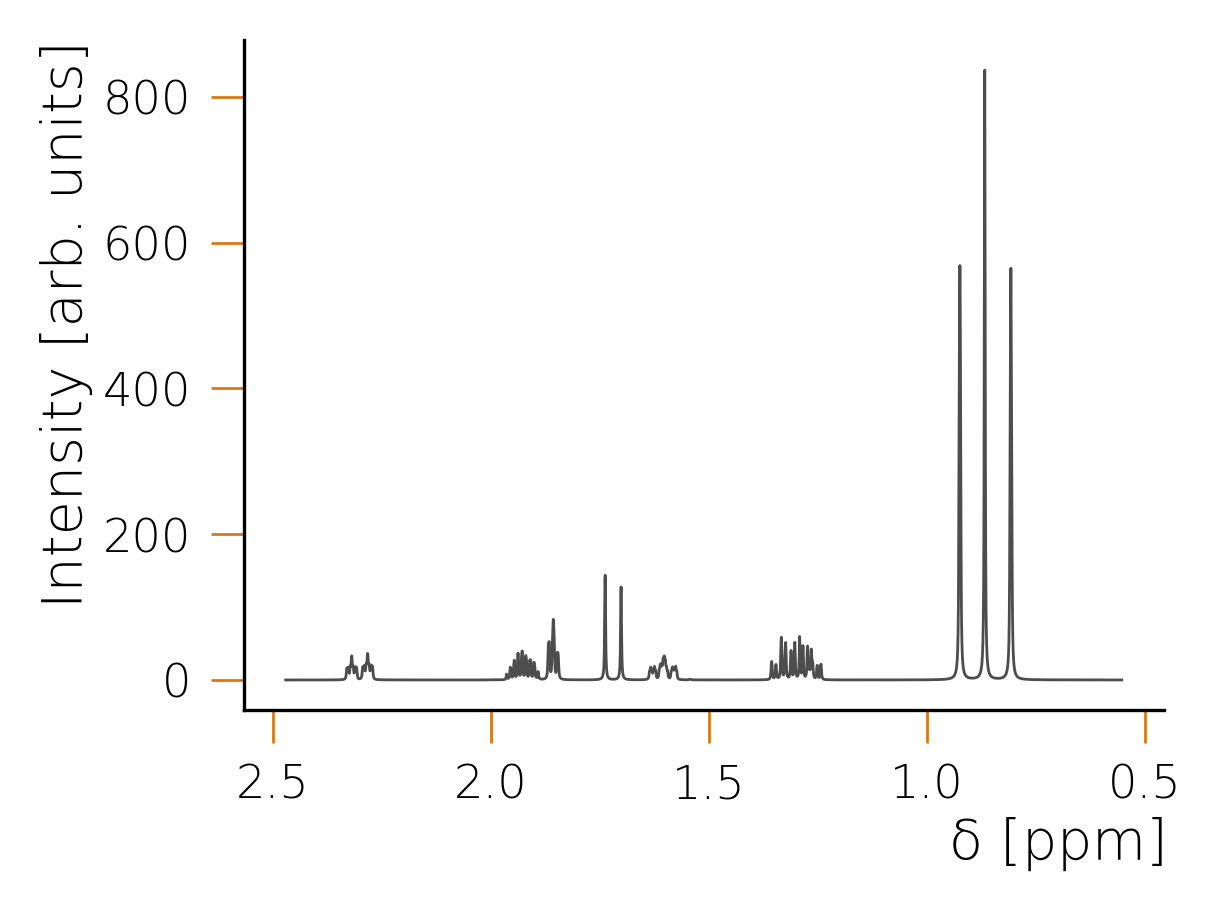

In [11]:
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433, fwhm_Hz=1.0, solver_settings=solver_settings
)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

Note that we specify the FWHM in Hz, while the returned frequencies are given in ppm. You can read out the FWHM in ppm directly from the `NMRSpectrum1D` object. You can also read out the reference energy, which will allow you to easily switch between the units common in NMR (rad / s, Hz or ppm), for example:

In [12]:
print("fwhm [ppm] = ", spectrum.fwhm_ppm)
fwhm_Hz = conversion.ppm_to_Hz(spectrum.fwhm_ppm, calculation_parameters)
print("fwhm [Hz] = ", fwhm_Hz)
fwhm_rad_per_s = conversion.Hz_to_rad_per_s(fwhm_Hz)
print("fwhm [rad s^{-1}] = ", fwhm_rad_per_s)

fwhm [ppm] =  0.002000000030460597
fwhm [Hz] =  0.9999999999999999
fwhm [rad s^{-1}] =  6.283185307179585


Finally, we want to point out an advantage of our frequency solver approach over the time solvers often used for NMR spectrum calculations. Due to the fact that we can evaluate the spectral function directly at specific frequencies, we can zoom in into spectral features, by placing more frequency points in the region where the transitions are located. We can do this simply by defining a frequency window in which we want to zoom in. Let's say we are interested in the spectral feature between 1.2 and 1.4 ppm and calculate it using 4000 frequency points instead of the usual 2000 used by default:

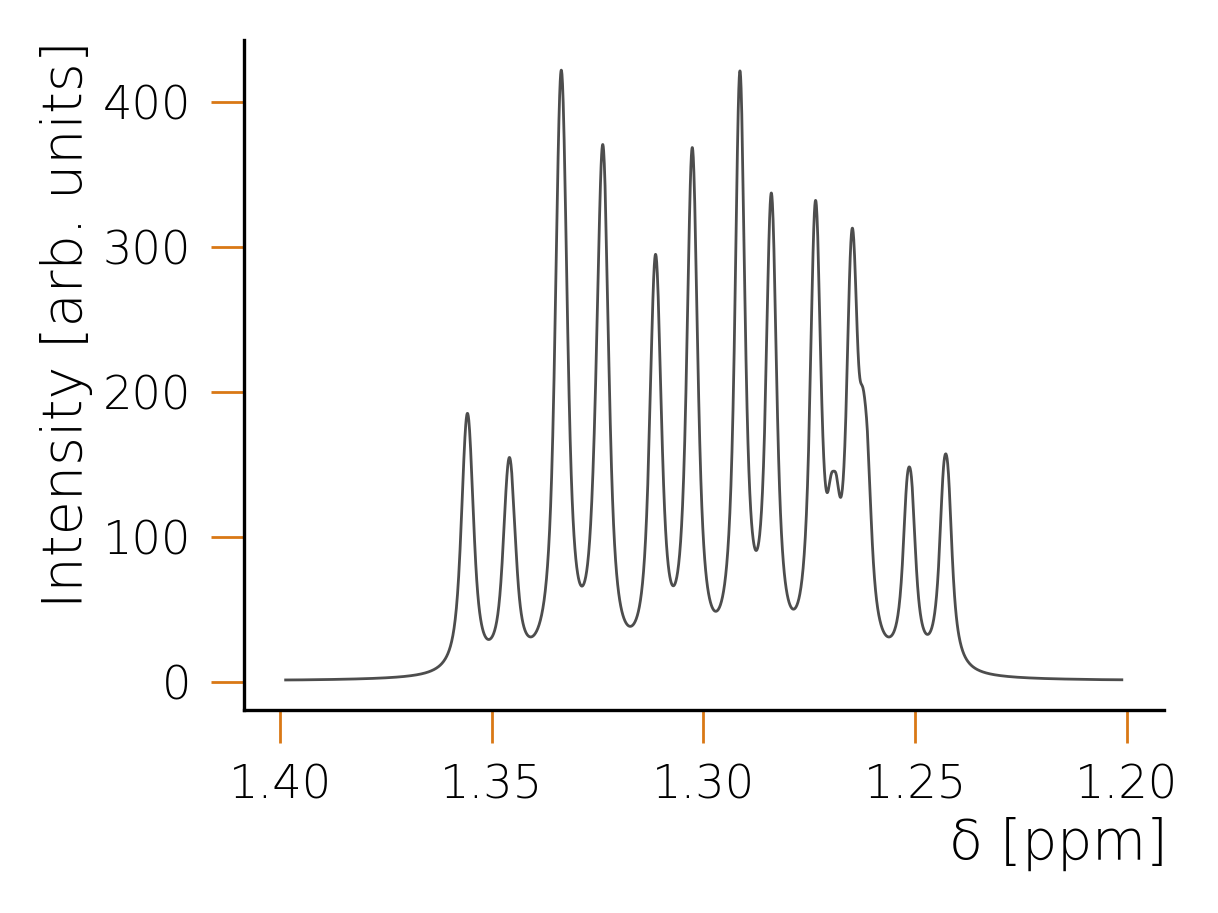

Number of frequency points: 4000


In [13]:
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433,
    number_omegas=4000,
    frequency_window_ppm=(1.2, 1.4),
    solver_settings=solver_settings,
)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

print(f"Number of frequency points: {len(spectrum.omegas_ppm)}")

Note that it is often necessary to also adjust the `fwhm_Hz` parameter, in order to resolve more features. This idea is also used internally in `calculate_spectrum`. The spectrum is solved once using a large broadening and only a few frequency points, which is then used to place more frequency points, where spectral weight was found.


## Other parameters

Another option you can specify is the temperature at which the spectrum is supposed to be calculated. You can do so by defining the absolute temperature in Kelvin:

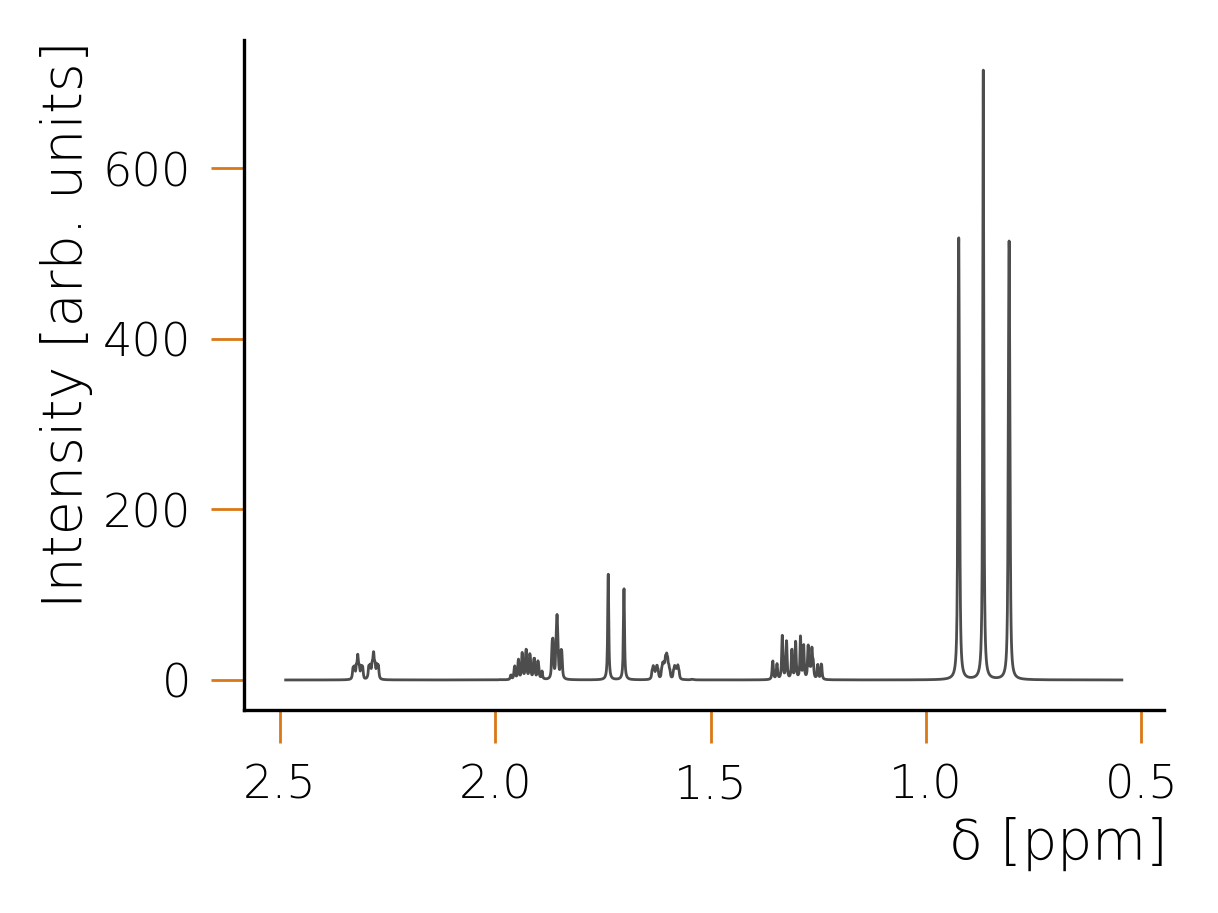

In [14]:
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433, temperature_K=300, solver_settings=solver_settings
)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

Finally, you have the option to specify your own set of gyromagnetic ratios. You specify them as a dictionary of `Isotope` and value:

{Isotope(mass_number=1, symbol='H'): 267522128.708, Isotope(mass_number=19, symbol='F'): 251815000.0}


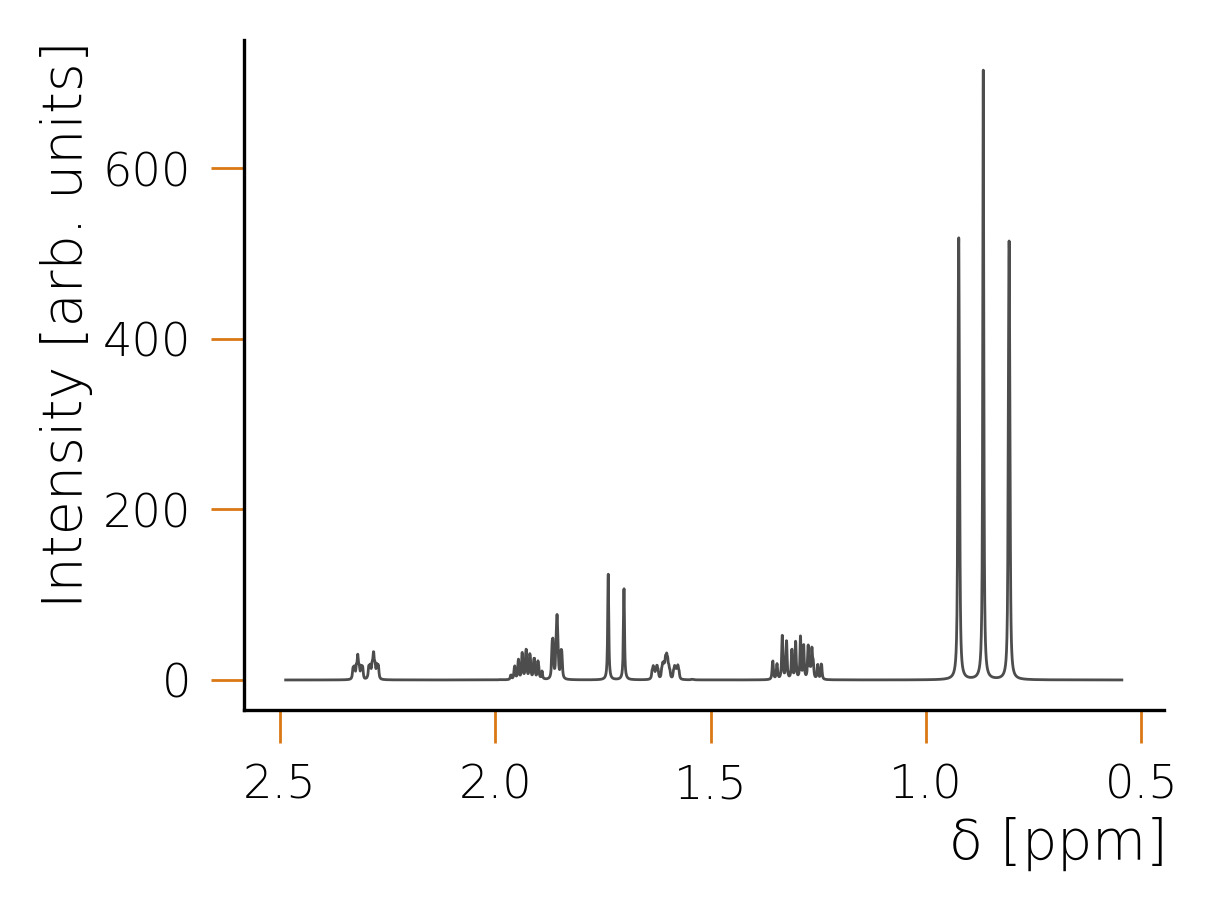

In [15]:
custom_gyromagnetic_ratios = {
    Isotope(mass_number=1, symbol="H"): 267522128.708,
    Isotope(mass_number=19, symbol="F"): 251815000,
}
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433,
    gyromagnetic_ratios=custom_gyromagnetic_ratios,
    solver_settings=solver_settings,
)
print(calculation_parameters.gyromagnetic_ratios)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum

plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

While there are a lot more options to customize the `calculate_spectrum` function via the `NMRSolverSettings` object, we advise to get first familiar with the parameters discussed so far and then check out the [API-documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/reference/index.html) for further options.